In [1]:
!pip install deepxde
!pip install matplotlib


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
%env DDE_BACKEND=tensorflow
import deepxde as dde
import numpy as np
from deepxde.backend import tf
import matplotlib.pyplot as plt

def func(x):
    return x * np.sin(5 * x)

def get_weights(denses):
    weights = np.concatenate([layer.get_weights()[0].flatten() for layer in denses])
    biases = np.concatenate([layer.get_weights()[1] for layer in denses])
    return weights

def train(model, iterations, display_every, loss, constant, norm_weights):
    prev_weight = None
    for i in range(iterations):
        model.train_state.set_data_train(
            *model.data.train_next_batch(model.batch_size)
        )
        model.train_step(
            model.train_state.X_train,
            model.train_state.y_train,
            model.train_state.train_aux_vars,
        )

        X_test, y_test = model.data.test()
        y_pred = model.predict(X_test)
        l2r = np.linalg.norm(y_pred - y_test) / np.linalg.norm(y_test)
        loss.append(l2r)

        w = get_weights(model.net.denses)
        norm_weights.append(np.linalg.norm(w))
        if model.train_state.epoch != 0:
            num_const = 0
            for i in range(len(w)):
                if w[i] == prev_weight[i]:
                    num_const += 1
            constant.append(100*num_const/len(w))
        prev_weight = w

        model.train_state.epoch += 1
        model.train_state.step += 1
        if model.train_state.step % display_every == 0 or i + 1 == iterations:
            print(str(model.train_state.step) + " " + str(loss[-1]))

def test(seed, plot=True):
    dde.config.set_default_float("float32")
    dde.config.set_random_seed(seed)
    print("Training Float32:")
    geom = dde.geometry.Interval(-1, 1)
    num_train = 16
    num_test = 100
    data = dde.data.Function(geom, func, num_train, num_test)

    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN([1] + [10] * 2 + [1], activation, kernel_initializer =  tf.keras.initializers.glorot_uniform(seed=seed))

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    loss_32 = []
    constant_32 = [0]
    norm_32 = []
    train(model, 10000, 1000, loss_32, constant_32, norm_32) # 10000
    print([constant_32[1]] + [constant_32[10]] + [constant_32[100]] + [constant_32[1000]] + [constant_32[9999]] )

    dde.config.set_default_float("float16")
    dde.config.set_random_seed(seed)
    print("Training Float16:")
    geom = dde.geometry.Interval(-1, 1)
    num_train = 16
    num_test = 100
    data = dde.data.Function(geom, func, num_train, num_test)

    activation = "tanh"
    initializer = "Glorot uniform"
    net = dde.nn.FNN([1] + [10] * 2 + [1], activation, kernel_initializer =  tf.keras.initializers.glorot_uniform(seed=seed))

    model = dde.Model(data, net)
    model.compile("adam", lr=0.001, metrics=["l2 relative error"])
    loss_16 = []
    constant_16 = [0]
    norm_16 = []
    train(model, 10000, 1000, loss_16, constant_16, norm_16) # 10000
    # print([constant_16[1]] + [constant_16[10]] + [constant_16[100]] + [constant_16[1000]] + [constant_16[9999]] )

    if plot:
        x = [i for i in range(len(loss_32))]
        plt.figure(figsize=(4.8,3.6))
        plt.ylabel('Percentage of constant weights')
        plt.xlabel('No. of iterations')
        plt.plot(x, constant_32, label = "Float32", color = 'red')
        plt.plot(x, constant_16, label = "Float16", color = 'orange')
        leg1 = plt.legend(loc = 'right', frameon=False)
        plt.savefig("constant-weights-" + str(seed) + ".pdf", bbox_inches='tight')
        plt.show()
    return (constant_32, constant_16, norm_32, norm_16)

env: DDE_BACKEND=tensorflow


2024-03-26 23:21:22.970740: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 23:21:22.996287: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 23:21:22.996314: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 23:21:22.996337: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-26 23:21:23.000826: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-26 23:21:23.001250: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
trials = 10
const_32 = np.zeros((trials, 10000))
const_16 = np.zeros((trials, 10000))
norm_32 = np.zeros((trials, 10000))
norm_16 = np.zeros((trials, 10000))
for i in range(trials):
    const_32[i], const_16[i], norm_32[i], norm_16[i] = test(i, False)

Set the default float type to float32
Training Float32:
Compiling model...
'compile' took 0.002713 s

1000 0.42378744
2000 0.27962446
3000 0.047656193
4000 0.039519608
5000 0.033346634
6000 0.026610268
7000 0.020320777
8000 0.017603723
9000 0.014633729
10000 0.012508991
[0.0, 0.0, 0.0, 0.0, 0.0]
Set the default float type to float16
Training Float16:
Compiling model...
'compile' took 0.003074 s

1000 0.3599
2000 0.168
3000 0.0795
4000 0.0686
5000 0.06476
6000 0.06323
7000 0.062
8000 0.06064
9000 0.06085
10000 0.0608
Set the default float type to float32
Training Float32:
Compiling model...
'compile' took 0.002237 s

1000 0.42936796
2000 0.0504884
3000 0.036177512
4000 0.02719491
5000 0.02487871
6000 0.02346393
7000 0.021664754
8000 0.01979175
9000 0.018077174
10000 0.016513951
[0.0, 0.0, 0.0, 0.0, 0.8333333333333334]
Set the default float type to float16
Training Float16:
Compiling model...
'compile' took 0.002158 s

1000 0.458
2000 0.4307
3000 0.401
4000 0.3364
5000 0.0944
6000 0.0768

(10000,)
(10000,)


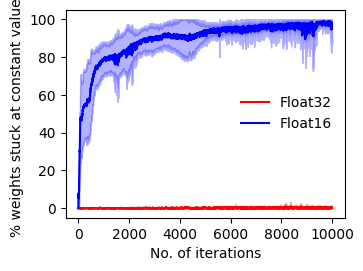

In [4]:
mean_32 = np.mean(const_32, axis = 0)
mean_16 = np.mean(const_16, axis = 0)
stdev_32 = np.std(const_32, axis = 0)
stdev_16 = np.std(const_16, axis = 0)

x = [i for i in range(len(mean_32))]
#plt.figure(figsize=(4.8,3.6))
plt.figure(figsize=(3.6,2.7))
plt.xlabel('No. of iterations')
plt.ylabel('% weights stuck at constant values')
plt.plot(x, mean_32, label = "Float32", color = 'red')
plt.plot(x, mean_16, label = "Float16", color = 'blue')
print((mean_32 - stdev_32).shape)
print(np.full(10000, 0).shape)
plt.fill_between(x, np.maximum(mean_32 - stdev_32, np.full(10000, 0)), np.minimum(mean_32 + stdev_32, np.full(10000, 100)), color = 'red', alpha = 0.3)
plt.fill_between(x, np.maximum(mean_16 - stdev_16, np.full(10000, 0)), np.minimum(mean_16 + stdev_16, np.full(10000, 100)), color = 'blue', alpha = 0.3)
leg1 = plt.legend(loc = 'right', frameon=False)
plt.savefig("constant-weights.pdf", bbox_inches='tight')
plt.show()

(10000,)
(10000,)


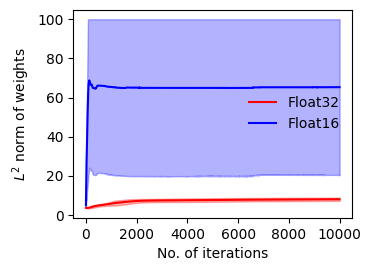

In [5]:
norm_mean_32 = np.mean(norm_32, axis = 0)
norm_mean_16 = np.mean(norm_16, axis = 0)
norm_stdev_32 = np.std(norm_32, axis = 0)
norm_stdev_16 = np.std(norm_16, axis = 0)

x = [i for i in range(len(norm_mean_32))]
#plt.figure(figsize=(4.8,3.6))
plt.figure(figsize=(3.6,2.7))
plt.xlabel('No. of iterations')
plt.ylabel('$L^2$ norm of weights')
plt.plot(x, norm_mean_32, label = "Float32", color = 'red')
plt.plot(x, norm_mean_16, label = "Float16", color = 'blue')
print((norm_mean_32 - norm_stdev_32).shape)
print(np.full(10000, 0).shape)
plt.fill_between(x, np.maximum(norm_mean_32 - norm_stdev_32, np.full(10000, 0)), np.minimum(norm_mean_32 + norm_stdev_32, np.full(10000, 100)), color = 'red', alpha = 0.3)
plt.fill_between(x, np.maximum(norm_mean_16 - norm_stdev_16, np.full(10000, 0)), np.minimum(norm_mean_16 + norm_stdev_16, np.full(10000, 100)), color = 'blue', alpha = 0.3)
leg1 = plt.legend(loc = 'right', frameon=False)
plt.savefig("norm-weights.pdf", bbox_inches='tight')
plt.show()

In [6]:
np.save("float32-norm-weights", norm_32)
np.save("float16-norm-weights", norm_16)

In [7]:
np.save("float32-constant-weights", const_32)
np.save("float16-constant-weights", const_16)

In [8]:
const_32 = np.load("./float32-constant-weights.npy")
const_16 = np.load("./float16-constant-weights.npy")
norm_32 = np.load("./float32-norm-weights.npy")
norm_16 = np.load("./float16-norm-weights.npy")

In [9]:
# the two times when we want to compare gradient and weight
TRAINING_I = 2
STAGNANT_I = 5_000

seed = 0
def get_gradients_of_weights(model16):
    gradients161d = np.concatenate([layer.numpy().ravel() for layer in gradients16])
    return gradients161d
dde.config.set_default_float("float32")
dde.config.set_random_seed(seed)

geom = dde.geometry.Interval(-1, 1)
num_train = 16
num_test = 100
data = dde.data.Function(geom, func, num_train, num_test)

activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN([1] + [10] * 2 + [1], activation, kernel_initializer =  tf.keras.initializers.glorot_uniform(seed=seed))

model = dde.Model(data, net)
model.compile("adam", lr=0.001, metrics=["l2 relative error"])

a = 0
b = 1

# also get individual weight values to do an in-depth analysis
iterations = 10_000
for i in range(iterations):
    model.train_state.set_data_train(
        *model.data.train_next_batch(model.batch_size)
    )
    model.train_step(
        model.train_state.X_train,
        model.train_state.y_train,
        model.train_state.train_aux_vars,
    )

    X_test, y_test = model.data.test()
    y_pred = model.predict(X_test)
    l2r = np.linalg.norm(y_pred - y_test) / np.linalg.norm(y_test)

    x_train = model.data.train_x
    y_train = model.data.train_y
    with tf.GradientTape() as tape:
        y_pred = model.net.call(x_train)
        loss_fn = dde.losses.get("MSE")
        loss = loss_fn(y_train, y_pred)
    gradients = tape.gradient(loss,model.net.trainable_weights)
    assert(gradients[2].shape == (10, 10)) # these are the gradients of the weights from hidden layer 1 -> 2
    layer1neuron1tolayer2neuron1_grad = gradients[2][a][b]
    print(np.mean(np.abs(gradients[2])))
    assert(model.net.denses[1].get_weights()[0].shape == (10,10))
    layer1neuron1tolayer2neuron1_weight = model.net.denses[1].get_weights()[0][a][b]
    if i == TRAINING_I or i == STAGNANT_I:
        print(layer1neuron1tolayer2neuron1_grad.numpy(), layer1neuron1tolayer2neuron1_weight)

    model.train_state.epoch += 1
    model.train_state.step += 1

Set the default float type to float32
Compiling model...
'compile' took 0.003517 s

0.08865395
0.08700533
0.08536006
0.08461694 0.22267543
0.08372368
0.0820958
0.08047307
0.07885346
0.07723627
0.07562158
0.074009776
0.07240143
0.07079721
0.069197886
0.06760426
0.06601723
0.06443774
0.06286684
0.06130558
0.059755024
0.058216177
0.056689993
0.055177294
0.053678825
0.052195277
0.050727244
0.04927529
0.047839962
0.046421733
0.045021076
0.04363842
0.04227417
0.040928725
0.03960242
0.03829561
0.037008606
0.035741717
0.034495197
0.033269353
0.03206441
0.030880606
0.029718183
0.028577344
0.027458293
0.026361233
0.02528634
0.024233792
0.023203759
0.022196403
0.021211874
0.02025031
0.019311847
0.018396609
0.017504716
0.016636256
0.015791325
0.014970009
0.014172366
0.013398444
0.012648277
0.011921878
0.011219247
0.01054035
0.009885148
0.009253565
0.008645499
0.008060831
0.00749941
0.006961056
0.006445557
0.0059526623
0.005482118
0.00503361
0.0046068127
0.004201353
0.0038168519
0.0034528761
0.0031